In [1]:
import pandas as pd
import os
import gc
import json
from pathlib import Path
import seaborn as sns
from copy import copy
sns.mpl.rcParams['axes.formatter.useoffset'] = False
sns.set_style('whitegrid')
import numpy as np
from collections import defaultdict
from scipy.interpolate import interp1d, interp2d, splrep, splev
from scipy.optimize import minimize, brentq
from itertools import product
%matplotlib inline

root = '../calc/2017-04-24-scan-modifications'
import sys
sys.path.append(root)
import caf
from caflib.Cellar import Cellar
from caflib.Utils import slugify
import vdwsets.vdwsets as vdw
from cscript import flatten, all_params

root_vdw = '../calc/2017-01-23-all-vdw-sets-3'

ev = 27.2107
kcal = 627.503

def get_some(d, *keys):
    for key in keys:
        if key in d:
            return d[key]
        
def normalize_names(col):
    if col.name == 'xc':
        return col.str.upper()
    return col

def savefig(name, **kwargs):
    sns.plt.savefig(os.path.expanduser('~/Downloads/fig.pdf'), transparent=True, **kwargs)

In [2]:
cellar = Cellar(f'{root}/.caf')
tree = cellar.get_tree(objects=True)

In [3]:
cellar_vdw = Cellar(f'{root_vdw}/.caf')
tree_vdw = cellar_vdw.get_tree(objects=True)

In [4]:
%%time
data_scf = []
data_mbd = []
for name, ds in vdw.get_all_datasets(include=['S22']).items():
    for key, cluster in ds.clusters.items():
        keypath = slugify('_'.join(map(str, key)))
        system = key[0]
        ref = cluster.energies['ref']
        for params in all_params:
            param_name = '_'.join(map(str, flatten(params))) if params else 'default'
            enes = {}
            for fragment in cluster.fragments:
                path = f'{name}/{keypath}/{fragment}/{param_name}'
                hashid = tree[path]
                filehash = tree.objects[hashid]['outputs']['results.json']
                with open(cellar.get_file(filehash)) as f:
                    results = json.load(f)
                enes[fragment] = results['scf_energy']
            data_scf.append((
                name, system, ' '.join(map(str, flatten(params))),
                cluster.get_int_ene(enes)/ev*kcal, ref
            ))
        enes = {}
        for fragment in cluster.fragments:
            path = f'{name}/{keypath}/{fragment}/mbd'
            hashid = tree_vdw[path]
            filehash = tree_vdw.objects[hashid]['outputs']['mbd.json']
            with open(cellar_vdw.get_file(filehash)) as f:
                results = json.load(f)
            enes[fragment] = list(sorted(results))
        for i, (beta, a, _) in enumerate(list(enes.values())[0]):
            data_mbd.append((
                name, system, a, beta, cluster.get_int_ene(
                    {f: enes[f][i][2] for f in cluster.fragments}
                )*kcal,
            ))
        data_mbd.append((name, system, 6., 10., 0.))
data_scf = pd.DataFrame.from_records(
    data_scf,
    columns='name system params ene ref'.split()
).set_index('name system params'.split(), verify_integrity=True).sort_index()
data_mbd = pd.DataFrame.from_records(
    data_mbd,
    columns='name system a beta ene'.split()
).set_index('name system a beta'.split(), verify_integrity=True).sort_index().xs(6, level='a')

CPU times: user 3.3 s, sys: 431 ms, total: 3.73 s
Wall time: 4.38 s


In [5]:
def get_stat(df):
    return pd.Series({
        'STD': df['reldelta'].std(),
        'mean': df['reldelta'].mean(),
        'MARE': abs(df['reldelta']).mean(),
        'MAE': abs(df['delta']).mean()
    })
    
def get_deltas(df):
    return df \
        .assign(delta=lambda x: x['ene']-x['ref']) \
        .assign(reldelta=lambda x: x['delta']/abs(x['ref']))

In [6]:
data = pd.merge(
    data_scf.reset_index(),
    data_mbd.reset_index(),
    on='name system'.split(),
    how='inner',
    suffixes=('_scf', '_mbd')
).set_index('name system params beta'.split()).sort_index() \
    .assign(ene=lambda x: x['ene_scf']+x['ene_mbd'])

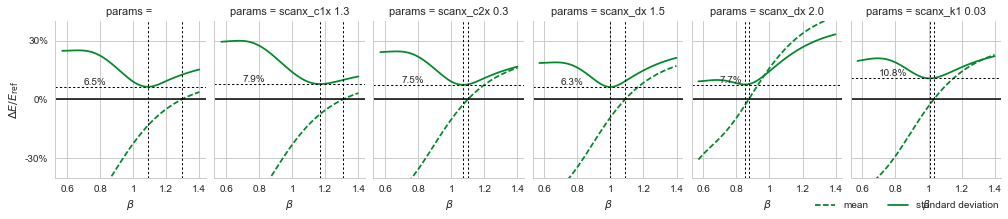

In [9]:
def plot_stat(**kwargs):
    global line1, line2
    df = kwargs.pop('data').groupby('beta').apply(get_stat).reset_index()
    mean = interp1d(df['beta'], df['mean'], kind='cubic')
    std = interp1d(df['beta'], df['STD'], kind='cubic')
    beta = np.linspace(df['beta'].min(), df['beta'].max())
    line1, = sns.plt.plot(beta, mean(beta), '--', color='#00882B')
    line2, = sns.plt.plot(beta, std(beta), '-', color='#00882B')
    bounds = [(df['beta'].min()+1e-6, df['beta'].max()-1e-6)]
    opt_std = minimize(std, 1.6, bounds=bounds).x[0]
    opt_mean = brentq(mean, *bounds[0]) \
            if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])) \
            else bounds[0][1]
    sns.plt.axhline(color='black', lw=1.5)
    sns.plt.axhline(std(opt_std), color='black', ls='dotted', lw=1)
    sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)
    sns.plt.text(.7, std(opt_std)+.01, f'{100*float(std(opt_std)):.1f}%')

g = sns.FacetGrid(
    data.loc['S22', slice(None), [
        '',
        'scanx_c1x 1.3',
        'scanx_c2x 0.3',
        'scanx_dx 1.5',
        'scanx_dx 2.0',
        'scanx_k1 0.03'
    ], slice(None, 1.5)]
    .pipe(get_deltas).reset_index(),
    col='params',
    margin_titles=True
).map_dataframe(plot_stat)
g.fig.legend(
    (line1, line2), ('mean', 'standard deviation'),
    loc='lower center', bbox_to_anchor=(.7, 0), ncol=2
)
g.fig.subplots_adjust(bottom=0.16, left=0.2, right=.93)
sns.plt.ylim(-.4, .4)
g.set_xlabels(r'$\beta$')
g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
xticks = [.6, .8, 1, 1.2, 1.4]
yticks = [-.3, 0, .3]
g.set(xticks=xticks, yticks=yticks)
g.set_xticklabels(xticks)
g.set_yticklabels(['-30%', '0%', '30%'])
# savefig('mbd-param-fitting')